Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from google.colab import drive


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_train = list(data_dir_train.glob('*/*.jpg'))
image_test = list(data_dir_test.glob('*/*.jpg'))

     

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
     

2239
118


### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds =  tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    
)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data

### create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
# code reference from https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python and other resources.
ls= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        ls.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
    

classes_name = [name for name in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, name))]
    
    #return dataframe with image count and class.
    

df = pd.DataFrame(list(zip(classes_name,ls)),columns =['Class', 'No. of Image'])
df

,Class,No. of Image
0,basal cell carcinoma,376
1,dermatofibroma,95
2,melanoma,438
3,actinic keratosis,114
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


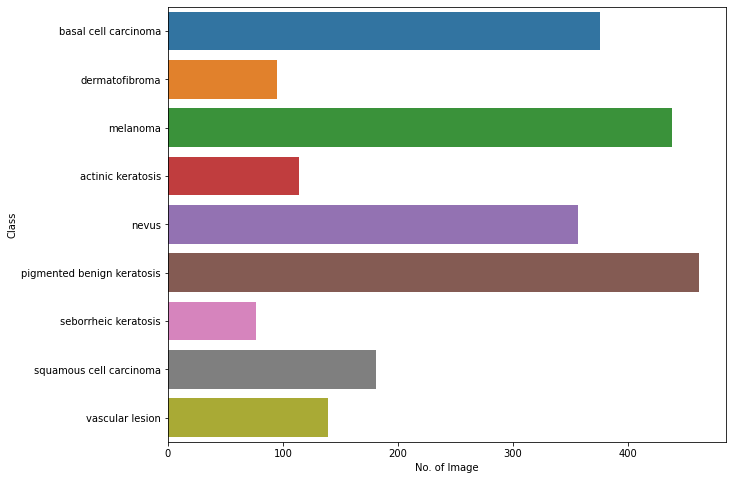

In [12]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [14]:
# model
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

## Compile the model

Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer= tf.keras.optimizers.Adadelta(),
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 176, 176, 32)      0         
                                                        

## Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 681s 3s/step - loss: 2.9974 - accuracy: 0.2729 - val_loss: 2.2220 - val_accuracy: 0.0559
Epoch 2/20
56/56 [==============================] - 6s 103ms/step - loss: 2.2482 - accuracy: 0.3544 - val_loss: 2.2732 - val_accuracy: 0.1521
Epoch 3/20
56/56 [==============================] - 6s 104ms/step - loss: 1.9422 - accuracy: 0.4012 - val_loss: 2.3524 - val_accuracy: 0.1477
Epoch 4/20
56/56 [==============================] - 6s 104ms/step - loss: 1.7014 - accuracy: 0.4615 - val_loss: 2.3874 - val_accuracy: 0.1544
Epoch 5/20
56/56 [==============================] - 6s 104ms/step - loss: 1.5013 - accuracy: 0.5028 - val_loss: 2.3269 - val_accuracy: 0.1857
Epoch 6/20
56/56 [==============================] - 6s 104ms/step - loss: 1.3711 - accuracy: 0.5357 - val_loss: 2.2027 - val_accuracy: 0.2327
Epoch 7/20
56/56 [==============================] - 6s 104ms/step - loss: 1.2883 - accuracy: 0.5463 - val_loss: 2.0198 - val_accuracy: 0.2819
Epoch 8

## Visualizing training results

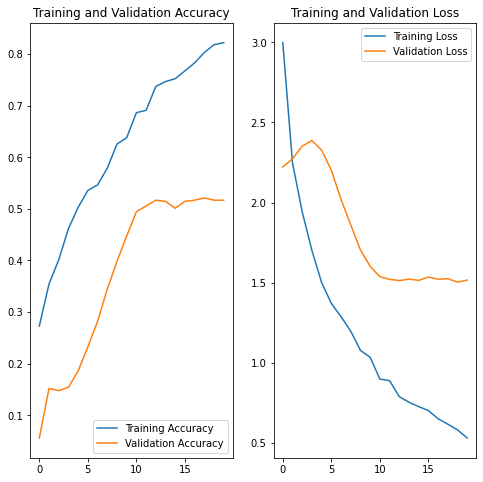

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above graph we can see that with increase in training accuracy the validation accuracy is decreasing. it is due to overfitting.

## data Agumentation to overcome overfitting


In [19]:
image_size = 180
batch_size = 32

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,validation_split = 0.2)
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_data_gen.flow_from_directory(data_dir_train, (image_size,image_size), batch_size=batch_size, class_mode='categorical',subset='training')
valid_generator = train_data_gen.flow_from_directory(data_dir_train, (image_size,image_size), batch_size=batch_size, class_mode='categorical',subset='validation')
test_generator = test_data_gen.flow_from_directory(data_dir_test, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


## Compiling the model

In [20]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer= tf.keras.optimizers.Adadelta(),
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

### Training the model

In [21]:
# Training the fully conncected layer for initial epochs
epochs = 20

# Training the model

history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)


Epoch 1/20
56/56 [==============================] - 55s 983ms/step - loss: 2.1806 - accuracy: 0.3659 - val_loss: 3.0150 - val_accuracy: 0.2812
Epoch 2/20
56/56 [==============================] - 51s 920ms/step - loss: 1.8933 - accuracy: 0.4095 - val_loss: 2.1760 - val_accuracy: 0.3221
Epoch 3/20
56/56 [==============================] - 51s 913ms/step - loss: 1.7854 - accuracy: 0.4214 - val_loss: 1.8914 - val_accuracy: 0.4038
Epoch 4/20
56/56 [==============================] - 51s 911ms/step - loss: 1.6596 - accuracy: 0.4668 - val_loss: 1.7501 - val_accuracy: 0.3918
Epoch 5/20
56/56 [==============================] - 51s 904ms/step - loss: 1.6075 - accuracy: 0.4714 - val_loss: 1.6802 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 49s 882ms/step - loss: 1.5473 - accuracy: 0.4957 - val_loss: 1.6254 - val_accuracy: 0.4375
Epoch 7/20
56/56 [==============================] - 49s 880ms/step - loss: 1.5236 - accuracy: 0.4878 - val_loss: 1.5650 - val_accuracy: 0.4471

### Visualizing the results

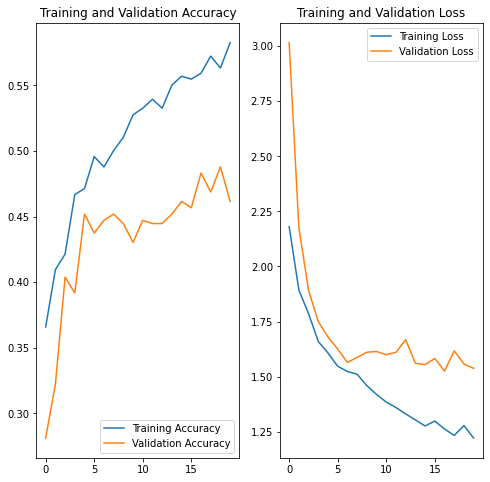

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the graph we can see that the overfitting is resolved using image argumentation.

In [23]:
# code reference from https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python and other resources.
ls= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        ls.append(len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]))
    

classes_name = [name for name in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, name))]
    
    #return dataframe with image count and class.
    

df = pd.DataFrame(list(zip(classes_name,ls)),columns =['Class', 'No. of Image'])
df

,Class,No. of Image
0,basal cell carcinoma,376
1,dermatofibroma,95
2,melanoma,438
3,actinic keratosis,114
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


There is imbalance in the dataset. "pigmented benign keratosis" is highest and "seborrheic keratosis" is least present in the dataset.

## Imbalance

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import Augmentor
path_train="/content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
for i in class_names:
    p = Augmentor.Pipeline(path_train + '/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDE7A8773D0>: 100%|██████████| 500/500 [00:20<00:00, 23.88 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE7A83F2B0>: 100%|██████████| 500/500 [00:23<00:00, 21.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDF6BAA8BE0>: 100%|██████████| 500/500 [00:18<00:00, 27.19 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=963x629 at 0x7FDE78324940>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7FDE7A86AC40>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE7B693A30>: 100%|██████████| 500/500 [00:17<00:00, 27.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDE78CBF2B0>: 100%|██████████| 500/500 [00:40<00:00, 12.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE783265E0>: 100%|██████████| 500/500 [00:17<00:00, 28.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/UpGrad/Melanoma Case Study/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDE7B6D6700>: 100%|██████████| 500/500 [00:17<00:00, 28.53 Samples/s]


In [27]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [28]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [29]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.20,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [30]:
image_size = 180
batch_size = 32

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,validation_split = 0.2)
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_data_gen.flow_from_directory(data_dir_train, (image_size,image_size), batch_size=batch_size, class_mode='categorical',subset='training')
valid_generator = train_data_gen.flow_from_directory(data_dir_train, (image_size,image_size), batch_size=batch_size, class_mode='categorical',subset='validation')
test_generator = test_data_gen.flow_from_directory(data_dir_test, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
# model
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

In [33]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer= tf.keras.optimizers.Adadelta(),
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [34]:
epochs = 30
history = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 135s 797ms/step - loss: 2.7117 - accuracy: 0.2667 - val_loss: 2.5163 - val_accuracy: 0.1012
Epoch 2/30
169/169 [==============================] - 124s 736ms/step - loss: 2.0460 - accuracy: 0.3663 - val_loss: 2.5256 - val_accuracy: 0.1488
Epoch 3/30
169/169 [==============================] - 124s 732ms/step - loss: 1.7740 - accuracy: 0.4109 - val_loss: 1.9723 - val_accuracy: 0.2894
Epoch 4/30
169/169 [==============================] - 122s 723ms/step - loss: 1.6313 - accuracy: 0.4458 - val_loss: 1.3849 - val_accuracy: 0.4918
Epoch 5/30
169/169 [==============================] - 120s 712ms/step - loss: 1.5211 - accuracy: 0.4677 - val_loss: 1.2616 - val_accuracy: 0.5372
Epoch 6/30
169/169 [==============================] - 122s 722ms/step - loss: 1.4501 - accuracy: 0.4858 - val_loss: 1.2136 - val_accuracy: 0.5618
Epoch 7/30
169/169 [==============================] - 123s 726ms/step - loss: 1.3410 - accuracy: 0.5131 - val_loss: 1.1738 -

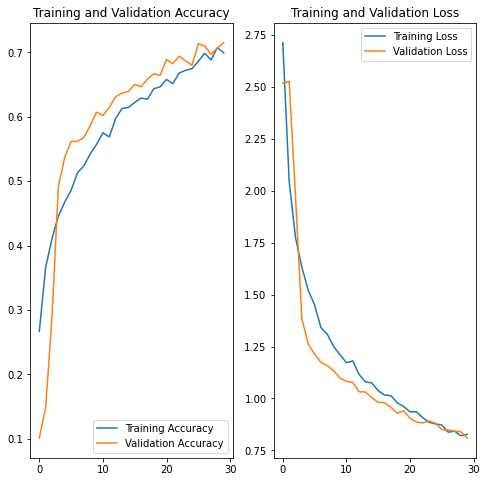

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the run history and graph we can see that overfitting is resolved and imbalance is resolved using Argumetor.